- Created by Akash Kharita (PhD student, University of Washington)
-05/26/2024

This notebook involves comparison of performance of the random forest model trained on the commbination of over physical and tsfel features for various sampling rates, window lengths, and frequency bands 

In [2]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os
import sys
sys.path.append('../src')

from utils import apply_cosine_taper
from utils import butterworth_filter
from utils import resample_array

import pickle
from zenodo_get import zenodo_get

from multiprocessing import Pool, cpu_count
from scipy.signal import resample
import pickle

In [92]:
def resample_array(arr, original_rate, desired_rate):
    num_samples = len(arr)
    duration = num_samples / original_rate  # Duration of the array in seconds
    new_num_samples = int(duration * desired_rate)
    return resample(arr, new_num_samples)




def process_file(h5_file, indices, buckets, times, win_before, win_after, pick_time, nos):
    data = []
    t = []
    with h5py.File(h5_file, 'r') as f:
        for i in tqdm(range(nos)):
            data.append(f['/data/' + buckets[i]][indices[i], 2, pick_time - win_before:pick_time + win_after])
            t.append(UTCDateTime(times[i]))
    return np.array(data), np.array(t)

def extract_features(data, t, cfg_file, fs):
    df = pd.DataFrame([])
    for i in tqdm(range(len(data))):
        try:
            tsfel_features = tsfel.time_series_features_extractor(cfg_file, data[i], fs=fs, verbose = 0)
            physical_features = seis_feature.FeatureCalculator(data[i], fs=fs).compute_features()
            final_features = pd.concat([tsfel_features, physical_features], axis=1)
            final_features['hod'] = t[i].hour - 8
            final_features['dow'] = t[i].weekday
            final_features['moy'] = t[i].month
            df = pd.concat([df, final_features])
        except:
            pass
  
    return df






label_encoder = LabelEncoder()
scaler = StandardScaler()
rf_model = RandomForestClassifier(random_state=42)
def return_classification_report(all_results):
    cr_all = []
    

    
    for result in tqdm(all_results):
        a, b, c, d = result[1][0], result[1][1], result[1][2], result[1][3]

        all_features = pd.concat([a, b, c, d])
        y = ['earthquake']*len(a) + ['explosion']*len(b) + ['surface']*len(c) + ['noise']*len(d)
        
        all_features['source'] = y
        all_features = all_features.dropna(axis=1)
        all_features.replace([np.inf, -np.inf], np.nan, inplace=True)
        all_features.dropna(inplace=True)
        
        x = all_features.drop(['source'], axis=1)
        y = all_features['source'].values

        
        scaled_features = scaler.fit_transform(x)
        x_scaled = pd.DataFrame(scaled_features, columns=x.columns)
        
        print(np.unique(y, return_counts = True))
        
        nus = min(1000,min(np.unique(y, return_counts = True)[1]))
        
        # Apply random undersampling using imbalanced-learn library
        rus = RandomUnderSampler(sampling_strategy={'earthquake':nus, 'explosion':nus, 'surface':nus, 'noise':nus})
        
        
        
        X_resampled, y_resampled = rus.fit_resample(x_scaled, y)
        y_num = label_encoder.fit_transform(y_resampled)


        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.3, random_state=42)
        
        
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        
        cr_all.append(classification_report(y_test, y_pred, output_dict=True))
        
    return cr_all


## Extracting the results

In [93]:
## Extracting for 40 Hz
# Define the path to your pickle file
file_path = '../results/results_40.pkl'

# Open the pickle file in read-binary mode
with open(file_path, 'rb') as file:
    # Load the content of the pickle file
    all_results_40 = pickle.load(file)
    

## Extracting for 50 Hz
# Define the path to your pickle file
file_path = '../results/results_50.pkl'

# Open the pickle file in read-binary mode
with open(file_path, 'rb') as file:
    # Load the content of the pickle file
    all_results_50 = pickle.load(file)


## Extracting for 100 Hz
# Define the path to your pickle file
#file_path = '../results/results_100.pkl'

# Open the pickle file in read-binary mode
#with open(file_path, 'rb') as file:
    # Load the content of the pickle file
#    all_results_100 = pickle.load(file)

## Extracting the results from the saved files

In [94]:
big_40 = []
big_50 = []
#big_100 = []

n_iter = 10

for i in tqdm(range(n_iter)):
    big_40.append(return_classification_report(all_results_40))
    big_50.append(return_classification_report(all_results_50))
    #big_100.append(return_classification_report(all_results_100))

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:06<02:29,  6.50s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:13<02:33,  6.97s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:20<02:24,  6.86s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:24<01:57,  5.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:30<01:51,  5.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:35<01:39,  5.51s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:39<01:26,  5.08s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:45<01:23,  5.24s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:51<01:22,  5.48s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:56<01:16,  5.46s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [01:02<01:11,  5.52s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [01:07<01:03,  5.32s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [01:12<00:59,  5.39s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [01:16<00:49,  4.99s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [01:20<00:41,  4.63s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [01:23<00:33,  4.22s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:27<00:28,  4.12s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:31<00:24,  4.05s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:36<00:20,  4.18s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:40<00:16,  4.07s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:45<00:13,  4.38s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:47<00:07,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:51<00:03,  3.89s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:57<00:00,  4.89s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:04<01:54,  4.98s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:09<01:48,  4.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:13<01:35,  4.56s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:18<01:30,  4.53s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:23<01:29,  4.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:29<01:30,  5.01s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:34<01:24,  4.97s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:39<01:24,  5.29s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:45<01:18,  5.23s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:52<01:22,  5.86s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:57<01:13,  5.62s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [01:03<01:09,  5.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [01:09<01:05,  5.96s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [01:15<00:58,  5.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [01:21<00:53,  5.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [01:26<00:44,  5.59s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:33<00:41,  5.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:40<00:38,  6.38s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:45<00:30,  6.09s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:50<00:22,  5.52s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:54<00:15,  5.18s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:59<00:10,  5.09s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [02:05<00:05,  5.51s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:06<02:32,  6.64s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:11<02:04,  5.65s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:16<01:51,  5.33s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:21<01:41,  5.05s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:27<01:45,  5.54s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:34<01:49,  6.08s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:41<01:46,  6.24s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:46<01:33,  5.86s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:53<01:32,  6.20s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:57<01:20,  5.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [01:02<01:08,  5.23s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [01:06<00:59,  4.98s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [01:10<00:52,  4.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [01:14<00:45,  4.58s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [01:18<00:39,  4.38s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [01:21<00:31,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:25<00:27,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:29<00:23,  3.89s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:33<00:20,  4.11s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:38<00:16,  4.24s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:42<00:12,  4.12s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:44<00:07,  3.66s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:48<00:03,  3.71s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:52<00:00,  4.70s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:04<01:37,  4.24s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:08<01:29,  4.05s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:11<01:21,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:16<01:20,  4.02s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:20<01:18,  4.14s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:24<01:12,  4.02s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:28<01:08,  4.01s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:32<01:03,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:35<00:58,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:40<00:55,  3.99s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:43<00:51,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [00:47<00:47,  3.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [00:51<00:43,  3.98s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [00:55<00:39,  3.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [00:59<00:34,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [01:03<00:31,  3.93s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:07<00:27,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:11<00:23,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:15<00:19,  3.99s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:19<00:15,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:23<00:11,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:27<00:07,  3.97s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [01:31<00:03,  4.00s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:03<01:29,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:07<01:21,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:10<01:15,  3.61s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:14<01:07,  3.39s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:17<01:07,  3.54s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:21<01:06,  3.71s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:25<01:04,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:29<01:01,  3.85s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:33<00:58,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:37<00:51,  3.70s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [00:41<00:48,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [00:44<00:45,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [00:49<00:42,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [00:52<00:38,  3.86s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [00:56<00:35,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [00:59<00:28,  3.53s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:03<00:25,  3.60s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:07<00:22,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:11<00:19,  3.85s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:15<00:15,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:18<00:11,  3.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:21<00:06,  3.47s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:25<00:03,  3.55s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:28<00:00,  3.71s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:04<01:32,  4.01s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:07<01:26,  3.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:11<01:22,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:15<01:19,  3.97s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:19<01:14,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:23<01:10,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:27<01:07,  3.94s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:31<01:02,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:35<00:58,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:39<00:55,  3.98s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:43<00:50,  3.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [00:46<00:46,  3.89s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [00:50<00:42,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [00:54<00:39,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [00:58<00:34,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [01:02<00:31,  3.99s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:06<00:27,  3.93s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:10<00:23,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:14<00:19,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:18<00:15,  3.89s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:22<00:11,  3.85s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:26<00:07,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [01:30<00:03,  3.94s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:04<01:33,  4.07s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:08<01:28,  4.02s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:11<01:23,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:15<01:13,  3.67s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:19<01:11,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:22<01:08,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:27<01:06,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:30<01:02,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:34<00:59,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:38<00:52,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [00:42<00:49,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [00:45<00:45,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [00:50<00:42,  3.89s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [00:54<00:38,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [00:57<00:34,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [01:00<00:28,  3.54s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:04<00:25,  3.60s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:08<00:22,  3.67s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:12<00:18,  3.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:15<00:15,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:19<00:11,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:22<00:06,  3.40s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:26<00:03,  3.51s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:29<00:00,  3.74s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:04<01:32,  4.02s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:07<01:25,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:11<01:19,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:15<01:18,  3.94s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:19<01:13,  3.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:23<01:08,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:26<01:05,  3.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:30<01:00,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:34<00:56,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:38<00:53,  3.83s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:42<00:49,  3.80s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [00:45<00:45,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [00:49<00:42,  3.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [00:53<00:37,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [00:57<00:33,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [01:01<00:31,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:05<00:26,  3.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:08<00:22,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:12<00:19,  3.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:16<00:15,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:20<00:11,  3.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:24<00:07,  3.89s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [01:28<00:03,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:03<01:31,  3.96s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:07<01:25,  3.89s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:11<01:20,  3.85s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:14<01:12,  3.62s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:18<01:10,  3.72s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:22<01:08,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:26<01:05,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:30<01:01,  3.85s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:34<00:57,  3.86s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:37<00:51,  3.65s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [00:41<00:48,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [00:45<00:44,  3.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [00:49<00:41,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [00:52<00:37,  3.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [00:56<00:33,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [00:59<00:27,  3.43s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:03<00:24,  3.52s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:06<00:21,  3.62s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:10<00:18,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:14<00:14,  3.70s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:18<00:11,  3.67s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:20<00:06,  3.35s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:24<00:03,  3.44s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:27<00:00,  3.67s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:03<01:29,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:07<01:22,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:11<01:17,  3.71s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:15<01:16,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:18<01:11,  3.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:22<01:07,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:26<01:03,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:30<00:59,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:33<00:56,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:37<00:53,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:41<00:49,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [00:45<00:45,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [00:49<00:43,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [00:53<00:38,  3.86s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [00:56<00:34,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [01:01<00:31,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:04<00:26,  3.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:08<00:22,  3.83s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:12<00:19,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:16<00:15,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:19<00:11,  3.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:24<00:07,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [01:27<00:03,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:04<01:32,  4.02s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:07<01:25,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:11<01:20,  3.85s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:14<01:12,  3.63s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:18<01:11,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:22<01:08,  3.80s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:26<01:06,  3.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:30<01:03,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:34<00:59,  3.96s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:38<00:52,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [00:42<00:49,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [00:46<00:46,  3.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [00:50<00:42,  3.89s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [00:53<00:38,  3.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [00:57<00:34,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [01:00<00:27,  3.48s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:04<00:25,  3.62s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:08<00:22,  3.71s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:12<00:19,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:15<00:15,  3.80s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:20<00:11,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:22<00:07,  3.55s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:26<00:03,  3.67s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:30<00:00,  3.78s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:04<01:37,  4.22s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:08<01:29,  4.09s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:12<01:26,  4.14s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:16<01:23,  4.18s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:20<01:17,  4.08s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:24<01:11,  3.98s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:28<01:08,  4.01s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:32<01:04,  4.03s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:36<01:00,  4.00s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:40<00:56,  4.05s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:44<00:52,  4.04s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [00:48<00:47,  3.94s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [00:52<00:43,  3.97s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [00:56<00:39,  3.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [00:59<00:34,  3.85s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [01:04<00:32,  4.02s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:08<00:27,  3.96s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:11<00:23,  3.94s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:15<00:19,  3.93s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:19<00:15,  3.93s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:23<00:11,  3.89s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:28<00:08,  4.05s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [01:31<00:04,  4.01s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:04<01:43,  4.49s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:08<01:31,  4.18s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:12<01:24,  4.03s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:15<01:15,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:19<01:12,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:23<01:10,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:27<01:07,  3.98s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:31<01:03,  3.97s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:35<00:59,  3.99s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:39<00:53,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [00:42<00:49,  3.80s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [00:46<00:45,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [00:51<00:43,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [00:54<00:38,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [00:58<00:34,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [01:01<00:28,  3.57s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:05<00:26,  3.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:09<00:22,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:13<00:18,  3.80s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:16<00:14,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:20<00:11,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:22<00:06,  3.34s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:26<00:03,  3.42s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:30<00:00,  3.76s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:03<01:25,  3.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:07<01:22,  3.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:11<01:17,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:14<01:15,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:18<01:10,  3.72s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:22<01:06,  3.71s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:26<01:03,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:29<00:59,  3.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:33<00:55,  3.71s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:37<00:53,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:41<00:48,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [00:45<00:45,  3.80s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [00:48<00:41,  3.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [00:52<00:37,  3.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [00:55<00:33,  3.67s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [00:59<00:29,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:03<00:25,  3.66s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:06<00:21,  3.62s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:10<00:18,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:14<00:14,  3.65s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:17<00:10,  3.66s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:21<00:07,  3.72s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [01:25<00:03,  3.70s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:03<01:30,  3.94s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:07<01:23,  3.80s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:11<01:18,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:14<01:10,  3.50s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:18<01:08,  3.59s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:21<01:05,  3.64s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:26<01:04,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:29<01:00,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:33<00:56,  3.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:36<00:50,  3.57s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [00:40<00:46,  3.61s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [00:43<00:43,  3.62s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [00:47<00:40,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [00:51<00:36,  3.68s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [00:55<00:33,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [00:57<00:26,  3.36s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:01<00:24,  3.47s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:05<00:21,  3.55s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:09<00:18,  3.65s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:12<00:14,  3.66s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:16<00:10,  3.66s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:19<00:06,  3.34s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:22<00:03,  3.43s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:26<00:00,  3.60s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:03<01:26,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:07<01:24,  3.86s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:11<01:18,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:15<01:16,  3.84s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:18<01:11,  3.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:22<01:06,  3.68s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:26<01:03,  3.72s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:29<00:59,  3.72s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:33<00:55,  3.70s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:37<00:52,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:41<00:48,  3.70s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [00:44<00:44,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [00:48<00:41,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [00:52<00:37,  3.70s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [00:55<00:33,  3.68s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [00:59<00:30,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:03<00:26,  3.72s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:07<00:22,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:10<00:18,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:14<00:14,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:18<00:11,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:22<00:07,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [01:26<00:03,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:03<01:29,  3.90s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:07<01:24,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:11<01:18,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:14<01:10,  3.53s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:18<01:08,  3.62s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:21<01:05,  3.64s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:25<01:03,  3.71s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:29<00:59,  3.72s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:33<00:55,  3.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:36<00:50,  3.59s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [00:40<00:47,  3.62s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [00:44<00:43,  3.65s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [00:47<00:40,  3.70s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [00:51<00:36,  3.68s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [00:55<00:33,  3.67s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [00:57<00:27,  3.41s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:01<00:24,  3.49s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:05<00:21,  3.52s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:09<00:18,  3.64s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:12<00:14,  3.65s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:16<00:10,  3.65s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:19<00:06,  3.35s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:22<00:03,  3.41s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:26<00:00,  3.59s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:03<01:27,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:07<01:22,  3.73s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:10<01:16,  3.63s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:14<01:15,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:18<01:10,  3.72s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:22<01:07,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:26<01:04,  3.78s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:30<01:00,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:33<00:56,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:37<00:53,  3.86s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:41<00:50,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [00:45<00:46,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [00:49<00:43,  3.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [00:53<00:39,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [00:57<00:34,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [01:01<00:31,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:05<00:27,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:08<00:22,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:12<00:19,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:16<00:15,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:20<00:11,  3.80s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:24<00:07,  3.91s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [01:28<00:03,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2750, 2756, 2602, 2702]))



  4%|▍         | 1/24 [00:04<01:34,  4.12s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2860, 2862, 2696, 2821]))



  8%|▊         | 2/24 [00:07<01:26,  3.94s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2956, 2959, 2803, 2992]))



 12%|█▎        | 3/24 [00:11<01:23,  3.98s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1018,  837,  922, 1175]))



 17%|█▋        | 4/24 [00:15<01:16,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2979, 2978, 2884, 3000]))



 21%|██        | 5/24 [00:19<01:13,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2971, 2853, 2998]))



 25%|██▌       | 6/24 [00:23<01:10,  3.92s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2741, 2754, 2598, 2703]))



 29%|██▉       | 7/24 [00:27<01:08,  4.03s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2853, 2858, 2693, 2826]))



 33%|███▎      | 8/24 [00:31<01:03,  4.00s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2960, 2805, 2993]))



 38%|███▊      | 9/24 [00:35<00:59,  3.98s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1009,  833,  909, 1184]))



 42%|████▏     | 10/24 [00:38<00:52,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2978, 2979, 2884, 3000]))



 46%|████▌     | 11/24 [00:42<00:49,  3.83s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2974, 2971, 2852, 2998]))



 50%|█████     | 12/24 [00:46<00:46,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2768, 2737, 2626, 2753]))



 54%|█████▍    | 13/24 [00:51<00:43,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2858, 2716, 2854]))



 58%|█████▊    | 14/24 [00:54<00:39,  3.93s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2966, 2817, 2991]))



 62%|██████▎   | 15/24 [00:58<00:34,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1110,  723,  930, 1239]))



 67%|██████▋   | 16/24 [01:01<00:28,  3.51s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2981, 2984, 2896, 3000]))



 71%|███████   | 17/24 [01:05<00:25,  3.69s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2976, 2981, 2867, 2998]))



 75%|███████▌  | 18/24 [01:09<00:22,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2763, 2744, 2619, 2751]))



 79%|███████▉  | 19/24 [01:13<00:19,  3.82s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2869, 2860, 2710, 2851]))



 83%|████████▎ | 20/24 [01:17<00:15,  3.83s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2954, 2965, 2821, 2991]))



 88%|████████▊ | 21/24 [01:20<00:11,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1097,  719,  933, 1238]))



 92%|█████████▏| 22/24 [01:23<00:06,  3.49s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2980, 2984, 2896, 3000]))



 96%|█████████▌| 23/24 [01:27<00:03,  3.61s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2980, 2866, 2998]))



100%|██████████| 24/24 [01:31<00:00,  3.80s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2865, 2852, 2719, 2820]))



  4%|▍         | 1/24 [00:04<01:37,  4.22s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2964, 2835, 2989]))



  8%|▊         | 2/24 [00:07<01:26,  3.94s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2966, 2975, 2877, 2999]))



 12%|█▎        | 3/24 [00:11<01:20,  3.83s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1788, 1587, 1832, 1775]))



 17%|█▋        | 4/24 [00:15<01:18,  3.95s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2936, 3000]))



 21%|██        | 5/24 [00:19<01:13,  3.85s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2983, 2909, 2999]))



 25%|██▌       | 6/24 [00:23<01:08,  3.79s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2851, 2851, 2700, 2819]))



 29%|██▉       | 7/24 [00:27<01:05,  3.85s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2962, 2817, 2988]))



 33%|███▎      | 8/24 [00:30<01:01,  3.81s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2972, 2862, 2999]))



 38%|███▊      | 9/24 [00:34<00:56,  3.76s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1744, 1575, 1802, 1763]))



 42%|████▏     | 10/24 [00:38<00:53,  3.83s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2985, 2925, 3000]))



 46%|████▌     | 11/24 [00:42<00:48,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2984, 2899, 2999]))



 50%|█████     | 12/24 [00:45<00:44,  3.74s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2863, 2861, 2751, 2858]))



 54%|█████▍    | 13/24 [00:49<00:41,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2960, 2970, 2851, 2990]))



 58%|█████▊    | 14/24 [00:53<00:37,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2982, 2892, 2999]))



 62%|██████▎   | 15/24 [00:56<00:33,  3.72s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1849, 1486, 1803, 1906]))



 67%|██████▋   | 16/24 [01:01<00:30,  3.83s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2943, 3000]))



 71%|███████   | 17/24 [01:04<00:26,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2975, 2985, 2922, 2999]))



 75%|███████▌  | 18/24 [01:08<00:22,  3.75s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2846, 2852, 2729, 2840]))



 79%|███████▉  | 19/24 [01:12<00:18,  3.77s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2955, 2968, 2836, 2988]))



 83%|████████▎ | 20/24 [01:16<00:15,  3.87s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2967, 2981, 2882, 2999]))



 88%|████████▊ | 21/24 [01:20<00:11,  3.88s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([1823, 1481, 1781, 1891]))



 92%|█████████▏| 22/24 [01:24<00:07,  3.98s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2983, 2986, 2932, 3000]))



 96%|█████████▌| 23/24 [01:28<00:03,  3.93s/it]

(array(['earthquake', 'explosion', 'noise', 'surface'], dtype=object), array([2973, 2986, 2911, 2999]))



100%|██████████| 10/10 [31:44<00:00, 190.42s/it]


In [95]:
# Function to extract F1 scores from cr_all
def extract_f1_scores(cr_all):
    f1_scores = []
    for i in range(24):
        f1_score = pd.DataFrame(cr_all[i]).loc['f1-score', 'macro avg']
        f1_scores.append(f1_score)
    return f1_scores

# Extract F1 scores for each sampling rate

big_f1_40 = []
big_f1_50 = []
#big_f1_100 = []



for i in range(n_iter):
    big_f1_40.append(extract_f1_scores(big_40[i]))
    big_f1_50.append(extract_f1_scores(big_50[i]))
 #   big_f1_100.append(extract_f1_scores(big_100[i]))

In [100]:
f1_scores_40 = np.mean(np.array(big_f1_40), axis = 0)
f1_scores_50 = np.mean(np.array(big_f1_50), axis = 0)

std_40 = np.std(np.array(big_f1_40), axis = 0)
std_50 = np.std(np.array(big_f1_50), axis = 0)
#f1_scores_100 = np.mean(np.array(big_f1_100), axis = 0)

## Remember we need to improve the evaluation process by taking equal number of elements in each class!!

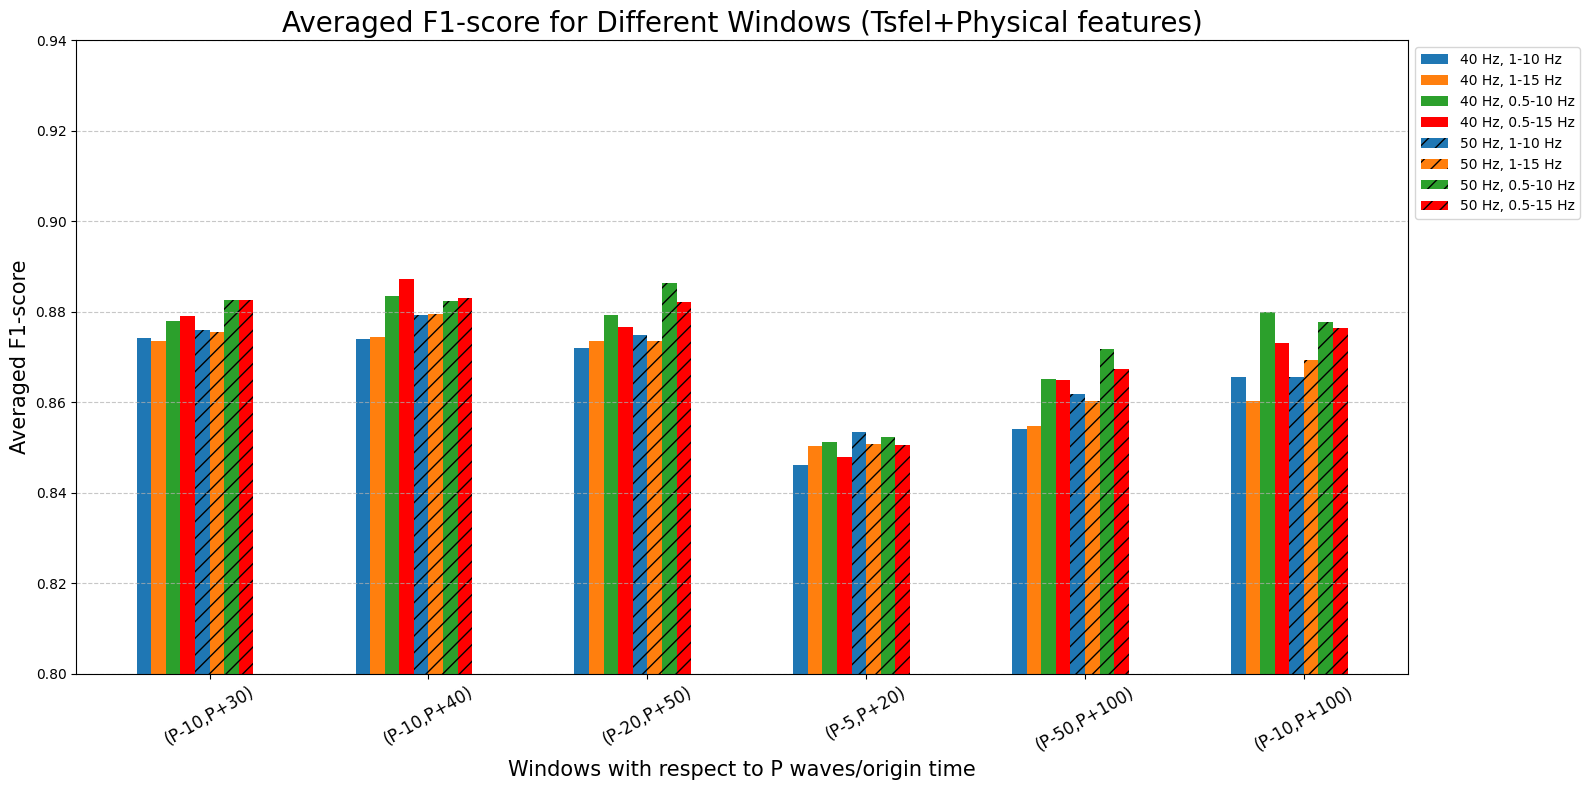

In [103]:
# Split F1 scores into frequency bands
f1_scores_1_10_40, f1_scores_1_15_40, f1_scores_05_10_40, f1_scores_05_15_40 = f1_scores_40[:6], f1_scores_40[6:12], f1_scores_40[12:18], f1_scores_40[18:24]
f1_scores_1_10_50, f1_scores_1_15_50, f1_scores_05_10_50, f1_scores_05_15_50 = f1_scores_50[:6], f1_scores_50[6:12], f1_scores_50[12:18], f1_scores_50[18:24]
f1_scores_1_10_100, f1_scores_1_15_100, f1_scores_05_10_100, f1_scores_05_15_100 = f1_scores_100[:6], f1_scores_100[6:12], f1_scores_100[12:18], f1_scores_100[18:24]

windows = ['(P-10,P+30)', '(P-10,P+40)', '(P-20,P+50)', '(P-5,P+20)', '(P-50,P+100)', '(P-10,P+100)']
bar_width = 0.20  # Width of each bar
index = np.arange(len(windows)) * 3  # Increase the separation between ticks

# Color blind friendly palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'red']

plt.figure(figsize=(16, 8))

# Plot for 40 Hz
plt.bar(index - 2 * bar_width, f1_scores_1_10_40, bar_width, label='40 Hz, 1-10 Hz', color=colors[0])
plt.bar(index - 1 * bar_width, f1_scores_1_15_40, bar_width, label='40 Hz, 1-15 Hz', color=colors[1])
plt.bar(index + 0 * bar_width, f1_scores_05_10_40, bar_width, label='40 Hz, 0.5-10 Hz', color=colors[2])
plt.bar(index + 1 * bar_width, f1_scores_05_15_40, bar_width, label='40 Hz, 0.5-15 Hz', color=colors[3])

# Plot for 50 Hz
plt.bar(index + 2 * bar_width, f1_scores_1_10_50, bar_width, label='50 Hz, 1-10 Hz', color=colors[0], hatch='//')
plt.bar(index + 3 * bar_width, f1_scores_1_15_50, bar_width, label='50 Hz, 1-15 Hz', color=colors[1], hatch='//')
plt.bar(index + 4 * bar_width, f1_scores_05_10_50, bar_width, label='50 Hz, 0.5-10 Hz', color=colors[2], hatch='//')
plt.bar(index + 5 * bar_width, f1_scores_05_15_50, bar_width, label='50 Hz, 0.5-15 Hz', color=colors[3], hatch='//')

# Plot for 100 Hz
#plt.bar(index + 6 * bar_width, f1_scores_1_10_100, bar_width, label='100 Hz, 1-10 Hz', color=colors[0], edgecolor='black', hatch='..')
#plt.bar(index + 7 * bar_width, f1_scores_1_15_100, bar_width, label='100 Hz, 1-15 Hz', color=colors[1], edgecolor='black', hatch='..')
#plt.bar(index + 8 * bar_width, f1_scores_05_10_100, bar_width, label='100 Hz, 0.5-10 Hz', color=colors[2], edgecolor='black', hatch='..')
#plt.bar(index + 9 * bar_width, f1_scores_05_15_100, bar_width, label='100 Hz, 0.5-15 Hz', color=colors[3], edgecolor='black', hatch='..')

# Add labels, title, and legend
plt.xlabel('Windows with respect to P waves/origin time', fontsize=15)
plt.ylabel('Averaged F1-score', fontsize=15)
plt.xticks(index + 2.5 * bar_width, windows, rotation=30, fontsize=12)
plt.ylim(0.80, 0.94)
plt.title('Averaged F1-score for Different Windows (Tsfel+Physical features)', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.grid(True, which='minor', linestyle='--', alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save or display the plot
plt.tight_layout()
plt.savefig('combined_f1_scores_plot.png', dpi=300)
plt.show()
